# Deep Learning with Python - Chapter 3

In [2]:
# A Dense layer with 32 outputs units
from keras import layers
layer = layers.Dense(32, input_shape=(784,))

Using TensorFlow backend.


We’re creating a layer that will only accept as input 2D tensors where the first dimen- sion is 784 (axis 0, the batch dimension, is unspecified, and thus any value would be accepted). This layer will return a tensor where the first dimension has been trans- formed to be 32. Thus this layer can only be connected to a downstream layer that expects 32- dimensional vectors as its input. When using Keras, you don’t have to worry about compatibility, because the layers you add to your models are dynamically built to match the shape of the incoming layer. For instance, suppose you write the following:


In [36]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(32, input_shape=(784,)))
model.add(layers.Dense(32))

The second layer didn’t receive an input shape argument—instead, it automatically inferred its input shape as being the output shape of the layer that came before.

In [ ]:
# A two-layered model using the Sequential class
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(784,)))
model.add(layers.Dense(10, activation='softmax'))

In [ ]:
# Same model as above using the functional API
input_tensor = layers.Input(shape=(784,))
x = layers.Dense(31, activation='relu')(input_tensor)
output_tensor = layers.Dense(10, activation='softmax')(x)

model = models.Model(input=input_tensor, outputs=output_tensor)


In [ ]:
# compile a model with a single loss function
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
             loss='mse',
             metrics=['accuracy'])

In [ ]:
# model.fit(input_tensor, target_tensor, batch_size=128, epochs=10)

### Binary Classificatioin Example: IMDB dataset

In [ ]:
from keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

The argument num_words=10000 means you’ll only keep the top 10,000 most fre- quently occurring words in the training data. Rare words will be discarded. This allows you to work with vector data of manageable size.

In [ ]:
# The variables train_data and test_data are lists of reviews; 
#each review is a list of word indices (encoding a sequence of words).
train_data[0]

In [ ]:
# train_labels and test_labels are lists of 0s and 1s, 
#where 0 stands for negative and 1 stands for positive:
train_labels[0]

In [ ]:
max([max(sequence) for sequence in train_data])

In [ ]:
# Decoding one of these review back to English
word_index = imdb.get_word_index()
reverse_word_index = dict (
    [(value, key) for (key, value) in word_index.items()])
decoded_review = ' '.join(
    [reverse_word_index.get(i - 3, '?') for i in train_data[0]])

##### Prepating the Data

In [ ]:
# Encoding the integer sequence into a binary matrix
import numpy as np

def vectorize_sequence(sequences, dimension=10000):
    results = np.zeros((len(sequences),dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequence(train_data)
x_test = vectorize_sequence(test_data)

In [ ]:
# Here is what the sample look like now
x_train[0]

In [ ]:
# You should also vectorize youk labesl, which is straightforward
train_labels

In [ ]:
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [ ]:
y_train

##### Building your network
The input data is vectors, and the labels are scalars (1s and 0s): this is the easiest setup you’ll ever encounter. A type of network that performs well on such a problem is a simple stack of fully connected (Dense) layers with relu activations: Dense(16, activation='relu'). The argument being passed to each Dense layer (16) is the number of hidden units of the layer.

In [ ]:
# Model implementation in keras
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(61, activation='relu', ))
model.add(layers.Dense(1, activation='sigmoid'))

Here’s the step where you configure the model with the rmsprop optimizer and the binary_crossentropy loss function. Note that you’ll also monitor accuracy during training.

In [ ]:
# Compiling the model
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])

You’re passing your optimizer, loss function, and metrics as strings, which is possible because rmsprop, binary_crossentropy, and accuracy are packaged as part of Keras. Sometimes you may want to configure the parameters of your optimizer or pass a cus- tom loss function or metric function. The former can be done by passing an optimizer class instance as the optimizer argument, as shown in listing 3.5; the latter can be done by passing function objects as the loss and/or metrics arguments, as shown in listing 3.6.

In [ ]:
# Configuring a custom optimizer (optional)
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=0.0001),
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [ ]:
# Using customr losses and metrics
from keras import losses
from keras import metrics

model.compile(optimizer=optimizers.RMSprop(lr=0.0001),
             loss=losses.binary_crossentropy,
             metrics=[metrics.binary_accuracy])

In [ ]:
# Setting aside a validation set
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

You’ll now train the model for 20 epochs (20 iterations over all samples in the x_train and y_train tensors), in mini-batches of 512 samples. At the same time, you’ll monitor loss and accuracy on the 10,000 samples that you set apart. You do so by passing the validation data as the validation_data argument.

In [ ]:
# Training your model

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data = (x_val, y_val))

Note that the call to model.fit() returns a History object. This object has a mem- ber history, which is a dictionary containing data about everything that happened during training. Let’s look at it:

In [ ]:
history_dict = history.history
history_dict.keys()

The dictionary contains four entries: one per metric that was being monitored during training and during validation. In the following two listing, let’s use Matplotlib to plot the training and validation loss side by side (see figure 3.7), as well as the training and validation accuracy (see figure 3.8). Note that your own results may vary slightly due to a different random initialization of your network.

In [ ]:
# Plotting the training and validation loss
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

# Fix: Use "history_dict['acc']" instead for the variable "acc"
acc = history_dict['acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Valdation loss')
plt.title('Training and Vatlidaiton loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Plotting the training and test validation accuracy 
plt.clf() #Clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

As you can see, the training loss decreases with every epoch, and the training accuracy increases with every epoch. That’s what you would expect when running gradient- descent optimization—the quantity you’re trying to minimize should be less with every iteration. But that isn’t the case for the validation loss and accuracy: they seem to peak at the fourth epoch. This is an example of what we warned against earlier: a model that performs better on the training data isn’t necessarily a model that will do better on data it has never seen before. In precise terms, what you’re seeing is overfit- ting: after the second epoch, you’re overoptimizing on the training data, and you end up learning representations that are specific to the training data and don’t generalize to data outside of the training set.In this case, to prevent overfitting, you could stop training after three epochs. More discussed in Chapter 4

In [ ]:
# Retraining the model from scratch

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy',
             metrics=['accuracy'])
model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

In [ ]:
results

This fairly naive approach achieves an accuracy of 88%. With state-of-the-art approaches, you should be able to get close to 95%.

##### Using a trained network

After having trained a network, you’ll want to use it in a practical setting. You can gen- erate the likelihood of reviews being positive by using the predict method:

In [ ]:
model.predict(x_test)

### Multiclass Classification: Classifying Newswires

In [ ]:
# Loading the Reuters dataset
from keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

In [ ]:
len(train_data)

In [ ]:
len(test_data)

In [ ]:
train_data[10]

In [ ]:
# Decoding newswires back to text
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()]) 
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [ ]:
# Training labels are in between 0 and 45
train_labels[10]

##### Preparing the data

In [ ]:
# Encoding Sequences into Tensors
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [ ]:
# One-Hot Encoding Categorical Values
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, labels] = 1
    return results

one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

In [ ]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

##### Model Definition

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

##### Compile the Model

In [ ]:
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

##### Setting aside a validation set

In [ ]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

##### Training the Model

In [ ]:
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=20,
                   batch_size=512,
                   validation_data=(x_val, y_val))

##### Plotting and training and validation loss

In [ ]:
# Plotting the training and validation loss
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Valdation loss')
plt.title('Training and Vatlidaiton loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Plotting the training and test validation accuracy 
plt.clf()

acc_values = history.history['acc']
val_acc_values = history.history['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

##### Retraining the model from scratch (nine epochs)

In [ ]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
             metrics=['accuracy'])
model.fit(partial_x_train,
         partial_y_train,
         epochs=9,
         batch_size=512,
         validation_data=(x_val, y_val))

results = model.evaluate(x_test, one_hot_test_labels)

In [ ]:
results


This approach reaches an accuracy of ~80%. With a balanced binary classification problem, the accuracy reached by a purely random classifier would be 50%. But in this case it’s closer to 19%, so the results seem pretty good, at least when compared to a random baseline:

In [ ]:
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
float(np.sum(hits_array)) / len(test_labels)

##### Generating predictions for new data

In [ ]:
predictions = model.predict(x_test)

In [ ]:
# Each entry in predictions is a vector of length 46:
predictions[0].shape

In [ ]:
# The coefficients in this vector sum to 1:
np.sum(predictions[0])

In [ ]:
# View all the probabilities for each class
predictions[0]

In [ ]:
# The largest entry is the predicted class—the class with the highest probability:
np.argmax(predictions[0])

##### A different way to handle the labels and the loss

In [ ]:
y_train = np.array(train_labels)
x_train = np.array(test_labels)

The only thing this approach would change is the choice of the loss function. The loss function used in listing 3.21, categorical_crossentropy, expects the labels to follow a categorical encoding. With integer labels, you should use sparse_categorical_ crossentropy:


In [ ]:
model.compile(optimizer='rmsprop', 
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

This new loss function is still mathematically the same as categorical_crossentropy;
it just has a different interface.

##### The importance of having sufficiently large intermediate layer 

We mentioned earlier that because the final outputs are 46-dimensional, you should avoid intermediate layers with many fewer than 46 hidden units. Now let’s see what happens when you introduce an information bottleneck by having intermediate layers that are significantly less than 46-dimensional: for example, 4-dimensional.

In [ ]:
# A model with a informational bottleneck
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model.fit(partial_x_train,
         partial_y_train,
         epochs =20, 
         batch_size=128, 
         validation_data=(x_val, y_val))

The network now peaks at ~71% validation accuracy, an 8% absolute drop. This drop is mostly due to the fact that you’re trying to compress a lot of information (enough information to recover the separation hyperplanes of 46 classes) into an intermediate space that is too low-dimensional. The network is able to cram most of the necessary information into these eight-dimensional representations, but not all of it.


### A Regression Example: Predicting House Prices

In [6]:
# loading the boston dataset
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [7]:
train_data.shape

(404, 13)

In [8]:
test_data.shape

(102, 13)

In [9]:
train_targets

array([ 15.2,  42.3,  50. ,  21.1,  17.7,  18.5,  11.3,  15.6,  15.6,
        14.4,  12.1,  17.9,  23.1,  19.9,  15.7,   8.8,  50. ,  22.5,
        24.1,  27.5,  10.9,  30.8,  32.9,  24. ,  18.5,  13.3,  22.9,
        34.7,  16.6,  17.5,  22.3,  16.1,  14.9,  23.1,  34.9,  25. ,
        13.9,  13.1,  20.4,  20. ,  15.2,  24.7,  22.2,  16.7,  12.7,
        15.6,  18.4,  21. ,  30.1,  15.1,  18.7,   9.6,  31.5,  24.8,
        19.1,  22. ,  14.5,  11. ,  32. ,  29.4,  20.3,  24.4,  14.6,
        19.5,  14.1,  14.3,  15.6,  10.5,   6.3,  19.3,  19.3,  13.4,
        36.4,  17.8,  13.5,  16.5,   8.3,  14.3,  16. ,  13.4,  28.6,
        43.5,  20.2,  22. ,  23. ,  20.7,  12.5,  48.5,  14.6,  13.4,
        23.7,  50. ,  21.7,  39.8,  38.7,  22.2,  34.9,  22.5,  31.1,
        28.7,  46. ,  41.7,  21. ,  26.6,  15. ,  24.4,  13.3,  21.2,
        11.7,  21.7,  19.4,  50. ,  22.8,  19.7,  24.7,  36.2,  14.2,
        18.9,  18.3,  20.6,  24.6,  18.2,   8.7,  44. ,  10.4,  13.2,
        21.2,  37. ,

##### Preparing Data

In [10]:
# Normalize the data
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= mean

##### Building your network

In [17]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

The network ends with a single unit and no activation (it will be a linear layer). This is a typical setup for scalar regression (a regression where you’re trying to predict a single continuous value). 

You’re also monitoring a new metric during training: mean absolute error (MAE). It’s the absolute value of the difference between the predictions and the targets. For instance, an MAE of 0.5 on this problem would mean your predictions are off by $500 on average.


##### K-Fold Cross Validation

In [19]:
import numpy as np
k = 4

num_val_samples = len(train_data)//k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]], 
        axis =0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]], 
        axis =0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
             epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, 
                                      verbose=0)
    all_scores.append(val_mae)
    

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [20]:
all_scores

[1.9447366837227698,
 2.8353559050229515,
 2.5371941339851607,
 2.3313016242319993]

In [21]:
np.mean(all_scores)

2.4121470867407204

Let’s try training the network a bit longer: 500 epochs. To keep a record of how well the model does at each epoch, you’ll modify the training loop to save the per- epoch validation score log.

In [24]:
# Saving the validation logs at each fold
import numpy as np
k = 4

num_val_samples = len(train_data)//k
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]], 
        axis =0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]], 
        axis =0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
             validation_data=(val_data, val_targets),
             epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


##### Building the history of successive mean K-fold validation scores

In [26]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

##### Plotting Validation Scores

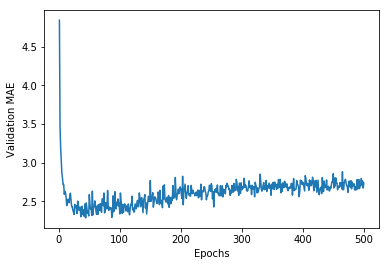

In [27]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

It may be a little difficult to see the plot, due to scaling issues and relatively high vari- ance. Let’s do the following:
- Omit the first 10 data points, which are on a different scale than the rest of the curve.
- Replace each point with an exponential moving average of the previous points,to obtain a smooth curve.

##### Plotting Validation Scores, excluding the first 10 data points

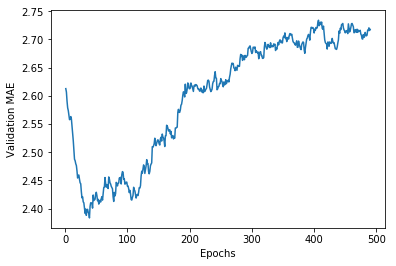

In [29]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

##### Training the Final Model

In [33]:
model = build_model()
model.fit(train_data, train_targets, epochs=80,
         batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 1ms/step


In [34]:
test_mae_score

7.5476257099824791